In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [26]:
!pip install flax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.3.2 which is incompatible.


In [25]:
!pip install jax

In [24]:
!pip install tensorcircuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.0/342.0 kB 9.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 16.1 MB/s eta 0:00:00


In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [4]:
class MNISTDataset(Dataset):
    def __init__(self, data_df:pd.DataFrame, transform=None, is_test=False):
        super(MNISTDataset, self).__init__()
        dataset = []
            
        for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
            data = row.to_numpy()
            if is_test:
                label = -1
                image = data.reshape(28, 28).astype(np.uint8)
            else:
                label = data[0]
                image = data[1:].reshape(28, 28).astype(np.uint8)
            
            if transform is not None:
                image = transform(image)
                    
            dataset.append((image, label))
        self.dataset = dataset
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        return self.dataset[i]

In [5]:
data_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
train_data = data_train.drop('label', axis=1).values
train_mean = train_data.mean()/255.
train_std = train_data.std()/255.
eval_count = 1000
train_transform = transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[train_mean], std=[train_std]),
])
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[train_mean], std=[train_std]),
])
test_transform = val_transform
# train_dataset = MNISTDataset(data_train.iloc[:-eval_count], default_transform)
train_dataset = MNISTDataset(data_train, train_transform) # use this to train the model on the full training set
eval_dataset = MNISTDataset(data_train.iloc[-eval_count:], val_transform)

  0%|          | 0/42000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
data_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
test_dataset = MNISTDataset(data_test, test_transform, is_test=True)

  0%|          | 0/28000 [00:00<?, ?it/s]

In [7]:
data_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
data_train.label.unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

In [9]:
data_train[data_train.label == 1].to_numpy()

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [10]:
row = data_train.iloc[1].to_numpy()
label = row[0]
digit_img = row[1:].reshape(28, 28)
print("label:",label)

label: 0


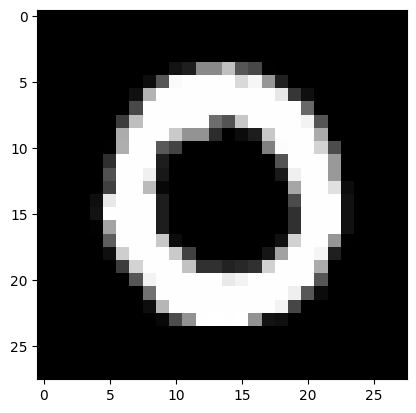

In [11]:
plt.imshow(digit_img, interpolation='nearest', cmap='gray')
plt.show()

In [12]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.9 MB/s eta 0:00:00


In [13]:
from einops import rearrange

In [14]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x
    
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [15]:
torch.manual_seed(42)

BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

In [16]:
import torch.nn.functional as F

def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

In [17]:
def evaluate(model, data_loader, loss_history):
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [18]:
import time

model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)
model = model.to(DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

train_loss_history, test_loss_history = [], []

In [19]:
N_EPOCHS = 100

# lambda1 = lambda epoch: epoch // 30
# lambda2 = lambda epoch: 0.95 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

start_time = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch,'LR:', scheduler.get_last_lr())
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, eval_loader, test_loss_history)
    scheduler.step()

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1 LR: [0.1]
[    0/42000 (  0%)]  Loss: 2.3242
[10000/42000 ( 24%)]  Loss: 2.1623
[20000/42000 ( 48%)]  Loss: 1.6863
[30000/42000 ( 71%)]  Loss: 1.4569
[40000/42000 ( 95%)]  Loss: 0.8872

Average test loss: 0.5540  Accuracy:  808/ 1000 (80.80%)

Epoch: 2 LR: [0.095]
[    0/42000 (  0%)]  Loss: 0.9230
[10000/42000 ( 24%)]  Loss: 0.6968
[20000/42000 ( 48%)]  Loss: 0.8771
[30000/42000 ( 71%)]  Loss: 0.5411
[40000/42000 ( 95%)]  Loss: 0.3563

Average test loss: 0.2184  Accuracy:  938/ 1000 (93.80%)

Epoch: 3 LR: [0.09025]
[    0/42000 (  0%)]  Loss: 0.5534
[10000/42000 ( 24%)]  Loss: 0.3451
[20000/42000 ( 48%)]  Loss: 0.2632
[30000/42000 ( 71%)]  Loss: 0.3104
[40000/42000 ( 95%)]  Loss: 0.4901

Average test loss: 0.1444  Accuracy:  953/ 1000 (95.30%)

Epoch: 4 LR: [0.0857375]
[    0/42000 (  0%)]  Loss: 0.4852
[10000/42000 ( 24%)]  Loss: 0.2459
[20000/42000 ( 48%)]  Loss: 0.5079
[30000/42000 ( 71%)]  Loss: 0.1935
[40000/42000 ( 95%)]  Loss: 0.2357

Average test loss: 0.1624  Accurac

In [20]:
submission_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

# Making it submission ready
submission = [['ImageId', 'Label']]

# Turn off gradients for validation
with torch.no_grad():
    model.eval()
    image_id = 1
    
    for images, _ in submission_loader:
        images = images.to(DEVICE)
        output = F.log_softmax(model(images), dim=1)
        _, pred = torch.max(output, dim=1)
        
        for prediction in pred:
            #print([image_id, prediction.item()])
            submission.append([image_id, prediction.item()])
            image_id += 1

In [21]:
submission_df = pd.DataFrame(submission)
submission_df.columns = submission_df.iloc[0]
submission_df = submission_df.drop(0, axis=0)
submission_df

,ImageId,Label
1,1,2
2,2,0
3,3,9
4,4,9
5,5,3
...,...,...
27996,27996,9
27997,27997,7
27998,27998,3
27999,27999,9


In [22]:
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

We can extend the classical vision transformer to a quantum vision transformer by making the following modification to the classical vision transformer architecture:

1. Leverage quantum circuits in the model architecture
2. Introduce quantum attention mechanisms 
3. Design novel methods for loading data and implementing trainable quantum orthogonal layers

## Sketch of The Quantum Vision Transformer Architecture

Quantum vision transformers involve the following in their architecture:

1. Quantum Data Loading : Quantum Vision Transformers load patches of data into quantum states using parametrized quantum circuits for efficient data representation

2. Quantum Attention Mechanism : Quantum Vision Transformers introduce quantum attention mechanisms based on compound matrices, offering a theoretical advantage over classical attention mechanisms in terms of runtime and model parameters

3. Trainable Quantum Orthogonal Layers: The architecture includes trainable orthogonal layers that can adapt to different levels of connectivity and the quality of quantum computers, enhancing the flexibility and the performance of the quantum vision transformers

4. Simulation and performance : Extensive simulations on medical image datasets demonstrate competitive or superior performance compared to classical benchmarks, showing the effective of quantum computers in image analysis tasks

5. Compound Transformer: A novel approach within the Quantum Vision Transformer architecture is the Compound Transformer, which loads all image patches in superposition and applies attention using an orthogonal matrix with trainable weights, showcasing a more natively quantum method for image analysis tasks

6. Quantum Circuit Design: Quantum circuits in the Quantum Vision Transformer architecture involve loading matrices as quantum states, applying quantum orthogonal layers, and utilizing specific amplitude encoding and hamming-weight preserving quantum gates for efficient computation